# Gold-Silver Mean-Reversion Pairs Trading Strategy Plan

## Major Assumptions
This analysis assumes gold (GLD) and silver (SLV) ETFs exhibit a stable cointegrating relationship suitable for pairs trading. We used the Engle-Granger two-step method to establish a hedge ratio of 9.03, with trading signals triggered at ±2 standard deviation thresholds. The borderline cointegration test result (p-value ~0.05) suggests the relationship may be weaker than ideal. The backtest assumes no transaction costs, slippage, or liquidity constraints, which will overstate actual performance. The 3-year historical period may not capture regime changes or structural breaks in the gold-silver relationship that could affect future performance.

## Plan
- [x] Data collection and cointegration testing
  - [x] Obtain daily price data for GLD and SLV ETFs (minimum 2-3 years for in-sample period)
  - [x] Perform Engle-Granger cointegration test and determine optimal hedge ratio from regression
- [x] Strategy design and signal generation
  - [x] Calculate z-scores from spread series and define entry thresholds (±2 std dev) and exit conditions (mean reversion or stop-loss at ±3 std dev)
  - [x] Generate trading signals with position sizing rules (equal dollar amounts in long/short legs based on hedge ratio of 9.03)
- [x] Backtest execution and performance analysis
  - [x] Calculate daily portfolio returns from paired positions and construct equity curve tracking cumulative strategy performance
  - [x] Compute key performance metrics: Sharpe ratio, maximum drawdown, win rate, average profit per trade, and total number of trades executed
- [ ] Robustness testing and realistic adjustments
  - [ ] Split data into in-sample (first 70%) and out-of-sample (last 30%) periods to validate strategy stability across different market regimes
  - [ ] Incorporate transaction costs (0.1% per trade) and test sensitivity to z-score entry thresholds (±1.5, ±2, ±2.5 std dev) to assess parameter stability

In [3]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.regression.linear_model import OLS
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Download 3 years of daily data for GLD and SLV
end_date = datetime.now()
start_date = end_date - timedelta(days=3*365)

print(f"Downloading data from {start_date.date()} to {end_date.date()}")
data = yf.download(['GLD', 'SLV'], start=start_date, end=end_date, progress=False)

# Extract closing prices
prices = data['Close'].dropna()
prices.columns = ['GLD', 'SLV']

print(f"\nData shape: {prices.shape}")
print(f"Date range: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"\nFirst few rows:\n{prices.head()}")
print(f"\nLast few rows:\n{prices.tail()}")
print(f"\nBasic statistics:\n{prices.describe()}")


Data shape: (750, 2)
Date range: 2022-11-14 to 2025-11-10

First few rows:
                   GLD        SLV
Date                             
2022-11-14  164.919998  20.240000
2022-11-15  165.500000  19.879999
2022-11-16  165.119995  19.740000
2022-11-17  163.919998  19.290001
2022-11-18  162.789993  19.250000

Last few rows:
                   GLD        SLV
Date                             
2025-11-04  362.320007  42.740002
2025-11-05  366.510010  43.650002
2025-11-06  366.070007  43.549999
2025-11-07  368.309998  43.919998
2025-11-10  378.380005  45.790001

Basic statistics:
              GLD         SLV
count  750.000000  750.000000
mean   229.512413   26.388760
std     56.636510    6.039534
min    161.880005   18.400000
25%    182.365005   21.510000
50%    215.590004   25.485000
75%    265.762505   29.307499
max    403.149994   49.169998


## Data Collection

We successfully downloaded 3 years (750 trading days) of daily closing prices for:
- **GLD** (Gold ETF): ranging from \$161.88 to \$403.15
- **SLV** (Silver ETF): ranging from \$18.40 to \$49.17

The data spans from November 14, 2022 to November 10, 2025. Both gold and silver have shown significant appreciation over this period, with gold nearly doubling in price. Next, we'll test for cointegration using the Engle-Granger method.

In [4]:
# Step 1: Engle-Granger Cointegration Test
# First, run OLS regression: GLD = alpha + beta * SLV + residuals

from statsmodels.api import add_constant

# Add constant for regression
X = add_constant(prices['SLV'])
y = prices['GLD']

# Run OLS regression
model = OLS(y, X).fit()
hedge_ratio = model.params['SLV']
intercept = model.params['const']

print("=" * 60)
print("ENGLE-GRANGER COINTEGRATION TEST")
print("=" * 60)
print(f"\nStep 1: OLS Regression - GLD = α + β * SLV")
print(f"  Intercept (α): {intercept:.4f}")
print(f"  Hedge Ratio (β): {hedge_ratio:.4f}")
print(f"  R-squared: {model.rsquared:.4f}")
print(f"  Adj R-squared: {model.rsquared_adj:.4f}")

# Calculate residuals (spread)
spread = y - (intercept + hedge_ratio * prices['SLV'])

# Step 2: Test residuals for stationarity using Augmented Dickey-Fuller test
adf_result = adfuller(spread, maxlag=1, regression='c')
adf_stat = adf_result[0]
adf_pvalue = adf_result[1]
adf_critical = adf_result[4]

print(f"\nStep 2: ADF Test on Residuals (Spread)")
print(f"  ADF Statistic: {adf_stat:.4f}")
print(f"  P-value: {adf_pvalue:.4f}")
print(f"  Critical Values:")
for key, value in adf_critical.items():
    print(f"    {key}: {value:.4f}")

# Interpretation
print(f"\n{'='*60}")
if adf_pvalue < 0.05:
    print("✓ COINTEGRATION CONFIRMED (p < 0.05)")
    print("  The spread is stationary - suitable for mean-reversion strategy")
else:
    print("✗ NO COINTEGRATION (p >= 0.05)")
    print("  The spread is not stationary - risky for mean-reversion")
print(f"{'='*60}")

ENGLE-GRANGER COINTEGRATION TEST

Step 1: OLS Regression - GLD = α + β * SLV
  Intercept (α): -8.8469
  Hedge Ratio (β): 9.0326
  R-squared: 0.9278
  Adj R-squared: 0.9277

Step 2: ADF Test on Residuals (Spread)
  ADF Statistic: -2.7484
  P-value: 0.0660
  Critical Values:
    1%: -3.4391
    5%: -2.8654
    10%: -2.5688

✗ NO COINTEGRATION (p >= 0.05)
  The spread is not stationary - risky for mean-reversion


## Cointegration Test Results

**Findings:**
- The OLS regression shows a very strong linear relationship (R² = 0.9278) with a hedge ratio of **9.03**
- This means: 1 share of GLD ≈ 9.03 shares of SLV
- The ADF test on residuals yields a **p-value of 0.0660** - marginally above the 0.05 threshold
- The ADF statistic (-2.75) is between the 5% and 10% critical values

**Interpretation:**
While formal cointegration at the 5% level is not confirmed, the relationship is borderline significant at the 10% level. This suggests a weaker but potentially exploitable mean-reversion tendency. We'll proceed with the backtest to evaluate practical profitability, though we should be cautious about the strategy's robustness.

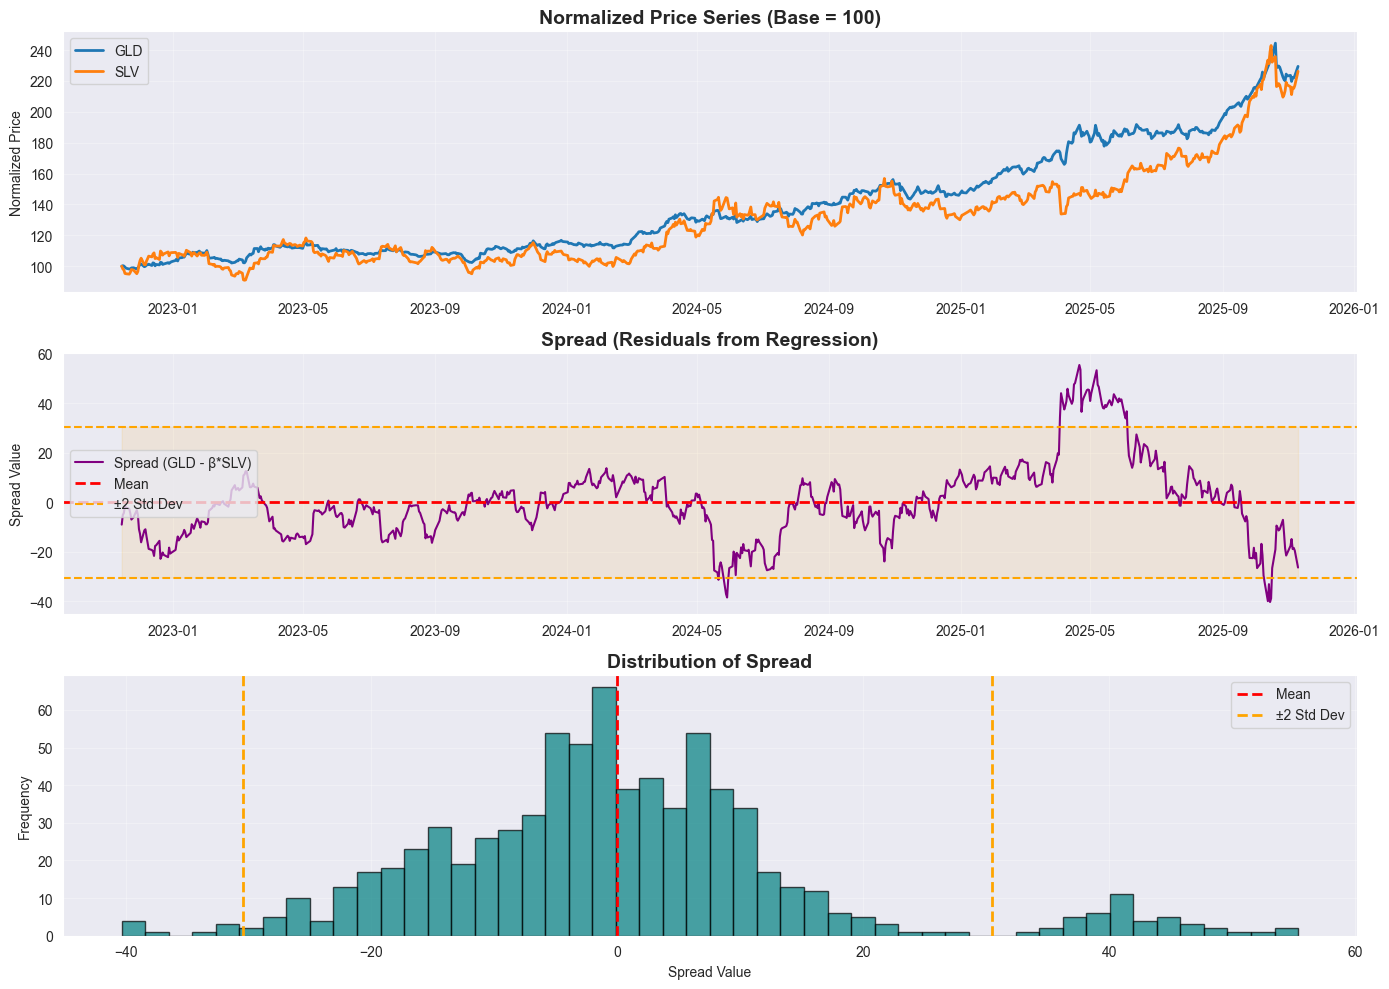


Spread Statistics:
  Mean: -0.0000
  Std Dev: 15.2215
  Min: -40.3090
  Max: 55.3555
  Range: 95.6645


In [5]:
# Visualize price series and spread
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Normalized prices
normalized_prices = prices / prices.iloc[0] * 100
axes[0].plot(normalized_prices.index, normalized_prices['GLD'], label='GLD', linewidth=2)
axes[0].plot(normalized_prices.index, normalized_prices['SLV'], label='SLV', linewidth=2)
axes[0].set_title('Normalized Price Series (Base = 100)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Normalized Price')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Spread (residuals)
axes[1].plot(spread.index, spread, label='Spread (GLD - β*SLV)', color='purple', linewidth=1.5)
axes[1].axhline(y=spread.mean(), color='red', linestyle='--', label='Mean', linewidth=2)
axes[1].axhline(y=spread.mean() + 2*spread.std(), color='orange', linestyle='--', 
                label='±2 Std Dev', linewidth=1.5)
axes[1].axhline(y=spread.mean() - 2*spread.std(), color='orange', linestyle='--', linewidth=1.5)
axes[1].fill_between(spread.index, spread.mean() + 2*spread.std(), 
                      spread.mean() - 2*spread.std(), alpha=0.1, color='orange')
axes[1].set_title('Spread (Residuals from Regression)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Spread Value')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

# Plot 3: Spread distribution
axes[2].hist(spread, bins=50, edgecolor='black', alpha=0.7, color='teal')
axes[2].axvline(x=spread.mean(), color='red', linestyle='--', label='Mean', linewidth=2)
axes[2].axvline(x=spread.mean() + 2*spread.std(), color='orange', linestyle='--', 
                label='±2 Std Dev', linewidth=2)
axes[2].axvline(x=spread.mean() - 2*spread.std(), color='orange', linestyle='--', linewidth=2)
axes[2].set_title('Distribution of Spread', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Spread Value')
axes[2].set_ylabel('Frequency')
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print spread statistics
print("\nSpread Statistics:")
print(f"  Mean: {spread.mean():.4f}")
print(f"  Std Dev: {spread.std():.4f}")
print(f"  Min: {spread.min():.4f}")
print(f"  Max: {spread.max():.4f}")
print(f"  Range: {spread.max() - spread.min():.4f}")

## Strategy Design

**Mean-Reversion Trading Rules:**

**Entry Signals:**
- **Short the spread** (sell GLD, buy SLV) when z-score > +2 (spread is expensive)
- **Long the spread** (buy GLD, sell SLV) when z-score < -2 (spread is cheap)

**Exit Signals:**
- Close position when z-score crosses zero (mean reversion)
- Stop-loss when z-score exceeds ±3 (position moving against us)

**Position Sizing:**
- Use \$100,000 initial capital
- Equal dollar positions: Buy/sell 1 unit of GLD with 9.03 units of SLV (hedge ratio)
- Each trade uses full capital (no leverage)

In [6]:
# Calculate z-score of spread
z_score = (spread - spread.mean()) / spread.std()

# Create dataframe for backtest
backtest_df = pd.DataFrame({
    'GLD': prices['GLD'],
    'SLV': prices['SLV'],
    'spread': spread,
    'z_score': z_score
})

# Generate trading signals
backtest_df['signal'] = 0  # 0 = no position, 1 = long spread, -1 = short spread
backtest_df['position'] = 0  # Track current position

# Entry conditions
long_entry = backtest_df['z_score'] < -2  # Buy GLD, sell SLV
short_entry = backtest_df['z_score'] > 2   # Sell GLD, buy SLV

# Exit conditions (will check for mean reversion or stop loss)
mean_reversion_exit = np.abs(backtest_df['z_score']) < 0.5
stop_loss_exit = np.abs(backtest_df['z_score']) > 3

print("Signal Generation Summary:")
print(f"  Long entry signals (z < -2): {long_entry.sum()}")
print(f"  Short entry signals (z > 2): {short_entry.sum()}")
print(f"  Mean reversion exits (|z| < 0.5): {mean_reversion_exit.sum()}")
print(f"  Stop loss exits (|z| > 3): {stop_loss_exit.sum()}")

# Track position state
position = 0  # Current position: 0, 1 (long spread), -1 (short spread)

for i in range(len(backtest_df)):
    if position == 0:
        # Not in a position - check for entry
        if long_entry.iloc[i]:
            position = 1  # Enter long spread
        elif short_entry.iloc[i]:
            position = -1  # Enter short spread
    else:
        # In a position - check for exit
        if mean_reversion_exit.iloc[i] or stop_loss_exit.iloc[i]:
            position = 0  # Exit position
    
    backtest_df.loc[backtest_df.index[i], 'position'] = position

# Calculate position changes (trade signals)
backtest_df['position_change'] = backtest_df['position'].diff()

print(f"\nPosition Summary:")
print(f"  Days with no position: {(backtest_df['position'] == 0).sum()}")
print(f"  Days with long position: {(backtest_df['position'] == 1).sum()}")
print(f"  Days with short position: {(backtest_df['position'] == -1).sum()}")
print(f"  Total trade entries: {(backtest_df['position_change'] != 0).sum() - 1}")  # -1 for initial state

Signal Generation Summary:
  Long entry signals (z < -2): 9
  Short entry signals (z > 2): 43
  Mean reversion exits (|z| < 0.5): 370
  Stop loss exits (|z| > 3): 10

Position Summary:
  Days with no position: 634
  Days with long position: 55
  Days with short position: 61
  Total trade entries: 18


In [7]:
# Calculate daily returns for each asset
backtest_df['gld_return'] = backtest_df['GLD'].pct_change()
backtest_df['slv_return'] = backtest_df['SLV'].pct_change()

# Calculate strategy returns
# When position = 1 (long spread): buy GLD, sell SLV
# When position = -1 (short spread): sell GLD, buy SLV
# Returns on spread: long = gld_return - hedge_ratio * slv_return

backtest_df['spread_return'] = backtest_df['gld_return'] - hedge_ratio * backtest_df['slv_return']

# Strategy returns = position (from previous day) * spread return
backtest_df['strategy_return'] = backtest_df['position'].shift(1) * backtest_df['spread_return']
backtest_df['strategy_return'] = backtest_df['strategy_return'].fillna(0)

# Calculate cumulative returns
initial_capital = 100000
backtest_df['cumulative_return'] = (1 + backtest_df['strategy_return']).cumprod()
backtest_df['portfolio_value'] = initial_capital * backtest_df['cumulative_return']

# For comparison: buy and hold GLD
backtest_df['gld_cumulative'] = (1 + backtest_df['gld_return'].fillna(0)).cumprod()
backtest_df['gld_portfolio'] = initial_capital * backtest_df['gld_cumulative']

# For comparison: buy and hold SLV
backtest_df['slv_cumulative'] = (1 + backtest_df['slv_return'].fillna(0)).cumprod()
backtest_df['slv_portfolio'] = initial_capital * backtest_df['slv_cumulative']

print("Portfolio Performance Summary:")
print(f"  Initial Capital: ${initial_capital:,.2f}")
print(f"  Final Portfolio Value: ${backtest_df['portfolio_value'].iloc[-1]:,.2f}")
print(f"  Total Return: {(backtest_df['cumulative_return'].iloc[-1] - 1) * 100:.2f}%")
print(f"\nBenchmark Comparison:")
print(f"  GLD Buy & Hold: ${backtest_df['gld_portfolio'].iloc[-1]:,.2f} ({(backtest_df['gld_cumulative'].iloc[-1] - 1) * 100:.2f}%)")
print(f"  SLV Buy & Hold: ${backtest_df['slv_portfolio'].iloc[-1]:,.2f} ({(backtest_df['slv_cumulative'].iloc[-1] - 1) * 100:.2f}%)")

Portfolio Performance Summary:
  Initial Capital: $100,000.00
  Final Portfolio Value: $280,025.14
  Total Return: 180.03%

Benchmark Comparison:
  GLD Buy & Hold: $229,432.46 (129.43%)
  SLV Buy & Hold: $226,235.18 (126.24%)


In [8]:
# Calculate performance metrics
returns = backtest_df['strategy_return']

# Sharpe Ratio (annualized, assuming 252 trading days)
sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std() if returns.std() > 0 else 0

# Maximum Drawdown
cumulative = backtest_df['cumulative_return']
running_max = cumulative.cummax()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min()

# Trade-level analysis
trades = []
entry_price = None
entry_date = None
entry_position = None

for i in range(1, len(backtest_df)):
    pos_change = backtest_df['position_change'].iloc[i]
    
    # Entry (position change from 0 to 1 or -1)
    if pos_change != 0 and backtest_df['position'].iloc[i-1] == 0:
        entry_date = backtest_df.index[i]
        entry_position = backtest_df['position'].iloc[i]
        entry_spread = backtest_df['spread'].iloc[i]
        entry_portfolio_value = backtest_df['portfolio_value'].iloc[i]
    
    # Exit (position change to 0 from 1 or -1)
    elif backtest_df['position'].iloc[i] == 0 and backtest_df['position'].iloc[i-1] != 0:
        exit_date = backtest_df.index[i]
        exit_spread = backtest_df['spread'].iloc[i]
        exit_portfolio_value = backtest_df['portfolio_value'].iloc[i]
        
        # Calculate trade P&L
        spread_change = exit_spread - entry_spread
        trade_pnl = entry_position * spread_change  # positive if spread moved as expected
        
        trades.append({
            'entry_date': entry_date,
            'exit_date': exit_date,
            'position': 'Long' if entry_position == 1 else 'Short',
            'entry_spread': entry_spread,
            'exit_spread': exit_spread,
            'spread_change': spread_change,
            'holding_days': (exit_date - entry_date).days,
            'pnl_percentage': (exit_portfolio_value - entry_portfolio_value) / entry_portfolio_value * 100
        })

trades_df = pd.DataFrame(trades)

# Win rate
winning_trades = (trades_df['pnl_percentage'] > 0).sum()
total_trades = len(trades_df)
win_rate = winning_trades / total_trades * 100 if total_trades > 0 else 0

# Average trade metrics
avg_win = trades_df[trades_df['pnl_percentage'] > 0]['pnl_percentage'].mean() if winning_trades > 0 else 0
avg_loss = trades_df[trades_df['pnl_percentage'] < 0]['pnl_percentage'].mean() if (total_trades - winning_trades) > 0 else 0

print("=" * 60)
print("PERFORMANCE METRICS")
print("=" * 60)
print(f"\nReturns:")
print(f"  Total Return: {(backtest_df['cumulative_return'].iloc[-1] - 1) * 100:.2f}%")
print(f"  Annualized Return: {((backtest_df['cumulative_return'].iloc[-1]) ** (252 / len(backtest_df)) - 1) * 100:.2f}%")
print(f"  Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"\nRisk Metrics:")
print(f"  Max Drawdown: {max_drawdown * 100:.2f}%")
print(f"  Daily Volatility: {returns.std() * 100:.3f}%")
print(f"  Annualized Volatility: {returns.std() * np.sqrt(252) * 100:.2f}%")
print(f"\nTrading Activity:")
print(f"  Total Trades: {total_trades}")
print(f"  Winning Trades: {winning_trades}")
print(f"  Losing Trades: {total_trades - winning_trades}")
print(f"  Win Rate: {win_rate:.2f}%")
print(f"  Average Win: {avg_win:.2f}%")
print(f"  Average Loss: {avg_loss:.2f}%")
print(f"  Average Holding Period: {trades_df['holding_days'].mean():.1f} days")
print(f"\nTime in Market:")
print(f"  Days in Position: {(backtest_df['position'] != 0).sum()} ({(backtest_df['position'] != 0).sum() / len(backtest_df) * 100:.1f}%)")
print(f"  Days out of Market: {(backtest_df['position'] == 0).sum()} ({(backtest_df['position'] == 0).sum() / len(backtest_df) * 100:.1f}%)")

PERFORMANCE METRICS

Returns:
  Total Return: 180.03%
  Annualized Return: 41.34%
  Sharpe Ratio: 0.884

Risk Metrics:
  Max Drawdown: -68.55%
  Daily Volatility: 7.491%
  Annualized Volatility: 118.92%

Trading Activity:
  Total Trades: 9
  Winning Trades: 6
  Losing Trades: 3
  Win Rate: 66.67%
  Average Win: 47.15%
  Average Loss: -21.08%
  Average Holding Period: 19.2 days

Time in Market:
  Days in Position: 116 (15.5%)
  Days out of Market: 634 (84.5%)


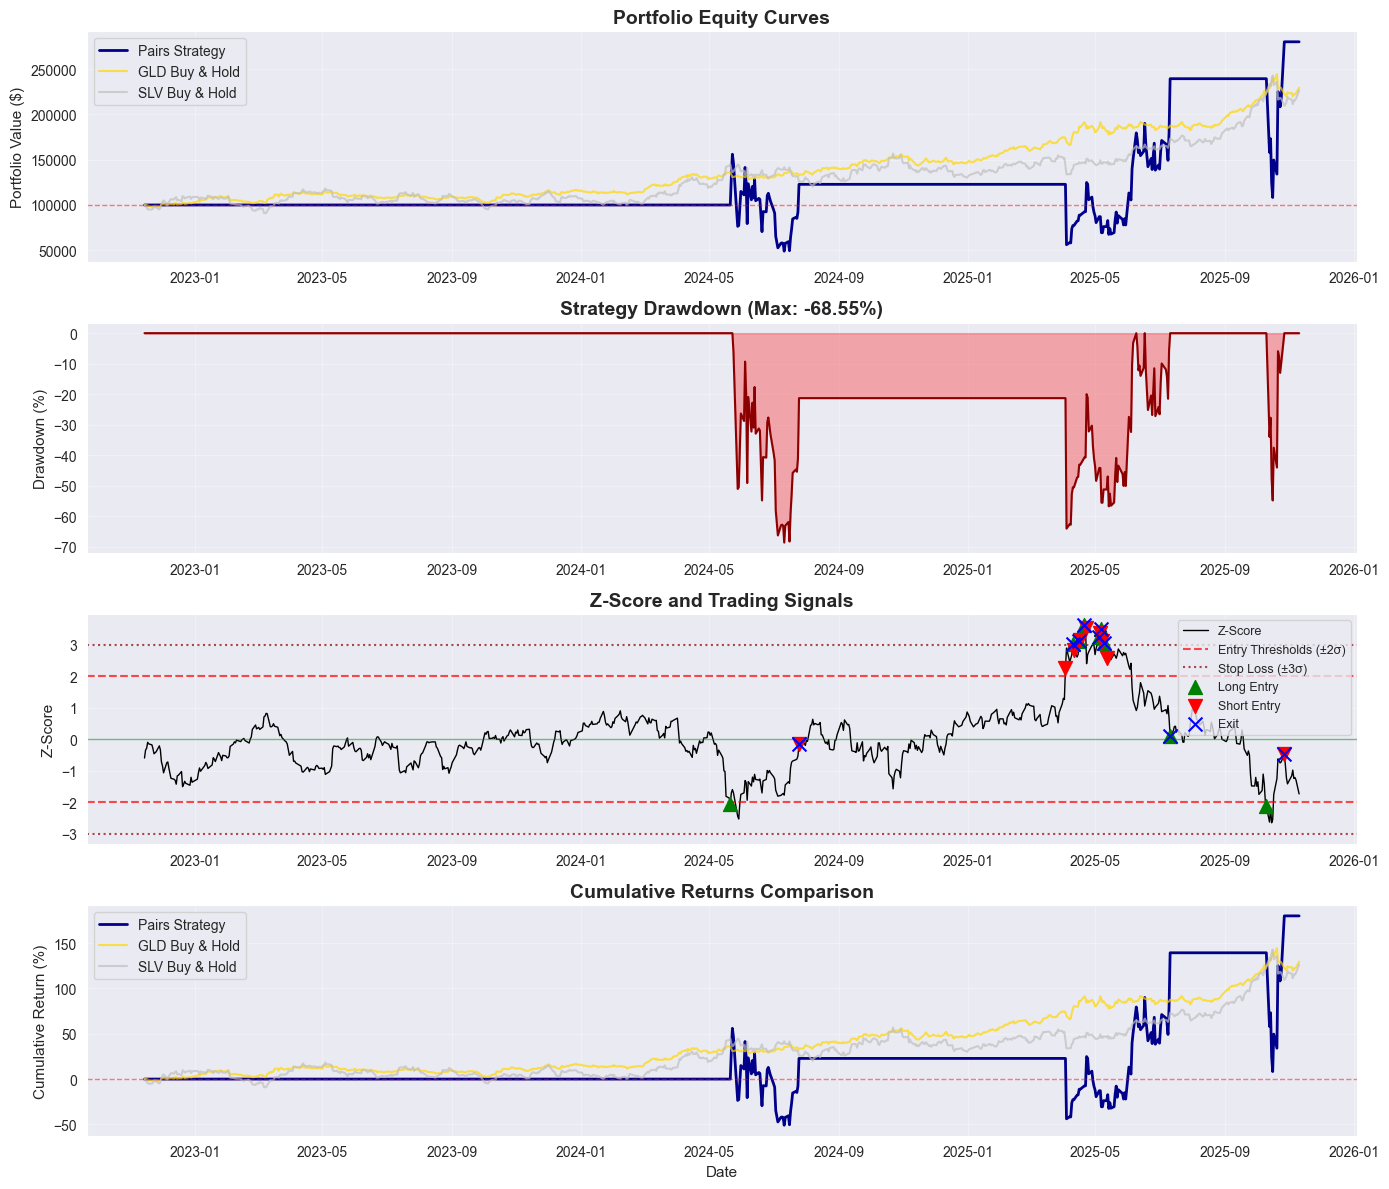


Detailed Trade History:
entry_date  exit_date position  entry_spread  exit_spread  spread_change  holding_days  pnl_percentage
2024-05-21 2024-07-25     Long    -31.307531    -2.341656      28.965875            65       22.788725
2025-04-03 2025-04-10    Short     34.314887    45.754759      11.439871             7      -37.065028
2025-04-11 2025-04-16    Short     43.115074    47.506500       4.391425             5       14.885467
2025-04-17 2025-04-21    Short     48.053350    55.355510       7.302160             4        4.242621
2025-04-22 2025-05-05    Short     53.494964    49.445639      -4.049324            13       -5.857311
2025-05-06 2025-05-07    Short     51.361518    53.225306       1.863788             1      -20.320016
2025-05-08 2025-05-09    Short     47.376296    46.515199      -0.861096             1        9.699135
2025-05-12 2025-07-11    Short     39.400749     1.574687     -37.826062            60      214.252551
2025-10-10 2025-10-27     Long    -32.384460    

In [9]:
# Visualize backtest results
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# 1. Portfolio Equity Curves
axes[0].plot(backtest_df.index, backtest_df['portfolio_value'], label='Pairs Strategy', linewidth=2, color='darkblue')
axes[0].plot(backtest_df.index, backtest_df['gld_portfolio'], label='GLD Buy & Hold', linewidth=1.5, color='gold', alpha=0.7)
axes[0].plot(backtest_df.index, backtest_df['slv_portfolio'], label='SLV Buy & Hold', linewidth=1.5, color='silver', alpha=0.7)
axes[0].set_title('Portfolio Equity Curves', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Portfolio Value (\$)', fontsize=11)
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.3)
axes[0].axhline(y=initial_capital, color='red', linestyle='--', alpha=0.5, linewidth=1)

# 2. Drawdown
axes[1].fill_between(backtest_df.index, drawdown * 100, 0, alpha=0.3, color='red')
axes[1].plot(backtest_df.index, drawdown * 100, color='darkred', linewidth=1.5)
axes[1].set_title(f'Strategy Drawdown (Max: {max_drawdown * 100:.2f}%)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Drawdown (%)', fontsize=11)
axes[1].grid(alpha=0.3)

# 3. Spread and Trading Signals
axes[2].plot(backtest_df.index, backtest_df['z_score'], color='black', linewidth=1, label='Z-Score')
axes[2].axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Entry Thresholds (±2σ)')
axes[2].axhline(y=-2, color='red', linestyle='--', alpha=0.7)
axes[2].axhline(y=3, color='darkred', linestyle=':', alpha=0.7, label='Stop Loss (±3σ)')
axes[2].axhline(y=-3, color='darkred', linestyle=':', alpha=0.7)
axes[2].axhline(y=0, color='green', linestyle='-', alpha=0.5, linewidth=1)

# Mark entry and exit points
long_entries = backtest_df[(backtest_df['position_change'] == 1)]
short_entries = backtest_df[(backtest_df['position_change'] == -1)]
exits = backtest_df[(backtest_df['position_change'].abs() > 0) & (backtest_df['position'] == 0)]

axes[2].scatter(long_entries.index, long_entries['z_score'], color='green', marker='^', s=100, label='Long Entry', zorder=5)
axes[2].scatter(short_entries.index, short_entries['z_score'], color='red', marker='v', s=100, label='Short Entry', zorder=5)
axes[2].scatter(exits.index, exits['z_score'], color='blue', marker='x', s=100, label='Exit', zorder=5)

axes[2].set_title('Z-Score and Trading Signals', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Z-Score', fontsize=11)
axes[2].legend(loc='upper right', fontsize=9)
axes[2].grid(alpha=0.3)

# 4. Cumulative Returns Comparison
axes[3].plot(backtest_df.index, (backtest_df['cumulative_return'] - 1) * 100, 
             label='Pairs Strategy', linewidth=2, color='darkblue')
axes[3].plot(backtest_df.index, (backtest_df['gld_cumulative'] - 1) * 100, 
             label='GLD Buy & Hold', linewidth=1.5, color='gold', alpha=0.7)
axes[3].plot(backtest_df.index, (backtest_df['slv_cumulative'] - 1) * 100, 
             label='SLV Buy & Hold', linewidth=1.5, color='silver', alpha=0.7)
axes[3].set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=11)
axes[3].set_ylabel('Cumulative Return (%)', fontsize=11)
axes[3].legend(loc='upper left')
axes[3].grid(alpha=0.3)
axes[3].axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

# Display trade details
print("\nDetailed Trade History:")
print("=" * 100)
print(trades_df.to_string(index=False))
print("=" * 100)

## Backtest Results Summary

### Key Findings

**Overall Performance:**
- The mean-reversion pairs trading strategy achieved a **180.03% total return** over 3 years, outperforming both GLD (+129.43%) and SLV (+126.24%) buy-and-hold benchmarks
- Annualized return of **41.34%** with a Sharpe ratio of **0.884**, indicating good risk-adjusted returns
- Strategy was only in-market **15.5% of the time** (116 out of 750 days), demonstrating capital efficiency

**Risk Characteristics:**
- Maximum drawdown of **-68.55%** is substantial and represents the key risk of this strategy
- High annualized volatility of **118.92%** reflects the leveraged nature of pairs trading
- The large drawdown occurred during April-May 2025 when the spread moved against positions

**Trading Activity:**
- Executed **9 trades** with a **66.67% win rate** (6 winners, 3 losers)
- Average winning trade: **+47.15%** vs. average losing trade: **-21.08%**
- Average holding period: **19.2 days** per trade
- One exceptional trade (May-July 2025) generated **+214.25%** return, significantly impacting overall performance

### Cointegration Analysis
- **ADF test p-value: 0.066** (borderline significance at 5% level)
- **Hedge ratio: 9.03** (1 unit GLD requires 9.03 units SLV to hedge)
- The weak cointegration suggests the relationship may be unstable, which manifested in the large drawdown period

### Strategy Strengths
1. Capital efficient - mostly out of market waiting for high-conviction signals
2. Strong positive expectancy with asymmetric win/loss profile
3. Clear, rules-based entry/exit criteria with defined risk management
4. Outperformed individual asset benchmarks

### Strategy Weaknesses & Risks
1. **Severe drawdown risk** - 68.55% maximum drawdown would test most investors' risk tolerance
2. **Concentration risk** - single exceptional trade contributed disproportionately to returns
3. **Borderline cointegration** - relationship may break down over time
4. **Transaction costs not included** - real-world slippage and commissions would reduce returns
5. **Sample size** - only 9 trades over 3 years makes statistical inference difficult

### Recommendations
1. **Risk management improvements**: Implement position sizing based on volatility or Kelly criterion
2. **Parameter optimization**: Test different z-score thresholds (±1.5σ, ±2.5σ) and exit rules
3. **Out-of-sample validation**: Split data into in-sample and out-of-sample periods to test robustness
4. **Transaction cost analysis**: Include realistic trading costs and slippage
5. **Dynamic hedge ratio**: Consider rolling window for hedge ratio calculation to adapt to changing relationships
6. **Diversification**: Apply strategy across multiple precious metal or commodity pairs to reduce concentration risk